# Вычисление центральностей у графа из друзей и друзей друзей в социальной сети ВК

Работу выполнили студенты группы БСМО-11-25:

* Аршинов Владислав (VK ID: `488243736`)
* Елохин Валерий (VK ID: `340121125`)
* Савин Даниил (VK ID: `326866301`)
* Якушенко Иван (VK ID: `219305476`)



In [ ]:
# Список VK ID авторов работы
CONTRIBUTORS = [488243736, 340121125, 326866301, 219305476]

-----
Импортируем необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque, defaultdict
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
import warnings

Загружаем данные

In [ ]:
data = pd.read_csv('friends.csv', encoding='utf-8')
data

,source,target
0,340121125,11582761
1,340121125,23810143
2,340121125,76142574
3,340121125,95176713
4,340121125,99228440
...,...,...
174020,832324541,1033797901
174021,832324541,1066367739
174022,1035453249,219305476
174023,1035453249,702027804


Убираем дубликаты строк в данных

In [ ]:
# Создаем столбец с отсортированными парами для идентификации дубликатов
data['sorted_pair'] = data.apply(lambda row: ','.join(sorted([str(row['source']), str(row['target'])])), axis=1)

# Удаляем дубликаты по отсортированным парам, сохраняя первую встреченную строку
data = data.drop_duplicates(subset=['sorted_pair'])

# Удаляем временный столбец
data = data.drop('sorted_pair', axis=1)
data

,source,target
0,340121125,11582761
1,340121125,23810143
2,340121125,76142574
3,340121125,95176713
4,340121125,99228440
...,...,...
174018,832324541,886453244
174019,832324541,896549934
174020,832324541,1033797901
174021,832324541,1066367739


## Центральность по собственному вектору

Алгоритм центральности по собственному вектору определяет важность вершины на основе важности её соседей.

Вершина считается тем более влиятельной, чем больше у неё связей с другими важными вершинами. Это рекурсивное понятие: важная вершина связана с другими важными вершинами. Математически это соответствует нахождению главного собственного вектора матрицы смежности графа, где каждая компонента вектора представляет центральность соответствующей вершины.

Проще говоря: "важность вершины = средняя важность её соседей".

Для начала, воспользуемся готовой библиотечной реализацией алгоритма, чтобы был ориентир

In [ ]:
centralities_lib = nx.eigenvector_centrality(G,10000)
centralities_lib

{340121125: 0.0025832454946508707,
 155805141: 0.002608463494461802,
 172710559: 0.034382299367022286,
 212397580: 0.002220441898561483,
 219305476: 0.07036203666910382,
 228061240: 0.0023415267744366195,
 236690140: 0.0024543089415461623,
 238384014: 0.0025591521221332556,
 240098981: 0.0025972387638073225,
 256262373: 0.0026277532277265356,
 282476961: 0.002556198457205438,
 316470083: 0.002564067067316755,
 318768118: 0.002558951590365903,
 320989644: 0.003443134784986828,
 322319926: 0.0024144127118100444,
 326807134: 0.002564067067316755,
 326866301: 0.0019392477560777046,
 334376173: 0.0024774700823961128,
 335892490: 0.00020355846346918965,
 386937989: 0.002523284788717457,
 465506973: 0.0026716006567165545,
 487664621: 0.002356158611984055,
 488243736: 0.0025871952086537753,
 538391105: 0.0022939276908328383,
 645236264: 0.002364411706980377,
 662741463: 0.0016374322722700117,
 25891559: 0.002078948575653193,
 342679381: 0.004523883256167683,
 2762541: 0.14291201326608968,
 789

Теперь создадим свою реализацию и прогоним данные через нее

In [ ]:
def eigenvector_centrality(df, max_iter=100, tol=1e-6):
    """
    Оптимизированная версия с экономией памяти
    """
    # Используем более эффективное создание mapping
    unique_nodes = np.union1d(df['source'].unique(), df['target'].unique())
    node_to_idx = {node: i for i, node in enumerate(unique_nodes)}
    n = len(unique_nodes)

    # Строим матрицу смежности более эффективно
    sources = df['source'].map(node_to_idx).values
    targets = df['target'].map(node_to_idx).values

    # Создаем разреженную матрицу
    A = csr_matrix((np.ones(len(sources), dtype=np.float32),
                   (sources, targets)), shape=(n, n))

    # Для неориентированного графа - делаем симметричной
    A = A + A.T
    A.data = np.ones_like(A.data)  # Убираем веса, оставляем только факт связи

    # Оптимизированный степенной метод
    n = A.shape[0]
    x = np.ones(n, dtype=np.float32) / n  # Начальное приближение

    for i in range(max_iter):
        # Умножение разреженной матрицы на вектор
        Ax = A.dot(x)

        # Нормализация
        norm = np.sqrt(np.dot(Ax, Ax))  # L2 норма

        if norm < 1e-12:
            break

        x_new = Ax / norm

        # Проверка сходимости
        if np.sqrt(np.dot(x_new - x, x_new - x)) < tol:
            x = x_new
            print(f"Сходимость достигнута на итерации {i+1}")
            break

        x = x_new

    centrality = np.abs(x)
    # centrality = centrality / centrality.sum()  # Нормализация

    return dict(zip(unique_nodes, centrality))

In [ ]:
centralities_custom = eigenvector_centrality(data, 10000)
centralities_custom

Сходимость достигнута на итерации 115


{np.int64(753): np.float32(1.2654531e-06),
 np.int64(2202): np.float32(0.0006067215),
 np.int64(2617): np.float32(2.2215186e-06),
 np.int64(2827): np.float32(9.483691e-07),
 np.int64(4492): np.float32(0.00015043971),
 np.int64(5005): np.float32(0.00015043971),
 np.int64(5286): np.float32(1.2928231e-06),
 np.int64(5523): np.float32(2.4554515e-06),
 np.int64(5792): np.float32(1.2840321e-05),
 np.int64(6945): np.float32(0.0006067215),
 np.int64(6962): np.float32(0.0009267405),
 np.int64(7361): np.float32(0.0024017121),
 np.int64(7751): np.float32(0.0045224703),
 np.int64(8236): np.float32(0.00015043971),
 np.int64(8791): np.float32(1.9766915e-06),
 np.int64(11105): np.float32(0.00015043971),
 np.int64(11946): np.float32(1.5306186e-06),
 np.int64(12022): np.float32(1.2840321e-05),
 np.int64(13121): np.float32(1.2840321e-05),
 np.int64(13311): np.float32(1.2840321e-05),
 np.int64(14195): np.float32(1.6546601e-06),
 np.int64(14603): np.float32(1.7203749e-05),
 np.int64(14739): np.float32(1.0

Центральности авторов работы согласно библиотечной функции:

In [ ]:
for user in CONTRIBUTORS:
  print(f"{user} -> {centralities_lib[user]}")

488243736 -> 0.0025871952086537753
340121125 -> 0.0025832454946508707
326866301 -> 0.0019392477560777046
219305476 -> 0.07036203666910382


Центральности авторов работы согласно самодельной функции:

In [ ]:
for user in CONTRIBUTORS:
  print(f"{user} -> {centralities_custom[user]}")

488243736 -> 0.004319425672292709
340121125 -> 0.0035358257591724396
326866301 -> 0.002722226083278656
219305476 -> 0.07233190536499023


Значения центральности совпадают с незначительными погрешностями

Последующие алгоритмы требуют очень много времени на выполнение. По нашим оценкам, обработка полного объема данных займет примерно 2,5 суток. С учетом этого, для последующих алгоритмов было принято решение использовать ограниченную выборку из авторов данной работы, их непосредственных друзей и еще 1000 наиболее центральных пользователей, согласно результатам вышеприведенного алгоритма.

In [ ]:
central_users = set(CONTRIBUTORS) | set(data[data["source"].isin(CONTRIBUTORS)]["target"])
count = 0
for u, _ in sorted([(k, v) for k, v in centralities_custom.items()], key=lambda p: p[1], reverse=True):
  if u not in central_users:
    central_users.add(u)
    count += 1
    if count == 1000:
      break
data = data[data["source"].isin(central_users)]
data = data[data["target"].isin(central_users)]
data

,source,target
0,340121125,11582761
1,340121125,23810143
2,340121125,76142574
3,340121125,95176713
4,340121125,99228440
...,...,...
173333,526134748,655654107
173338,526134748,697821476
173339,526134748,699796759
173803,574068734,662741463


Строим граф на основе отфильтрованных данных

In [ ]:
G = nx.from_pandas_edgelist(data)

Визуализируем граф

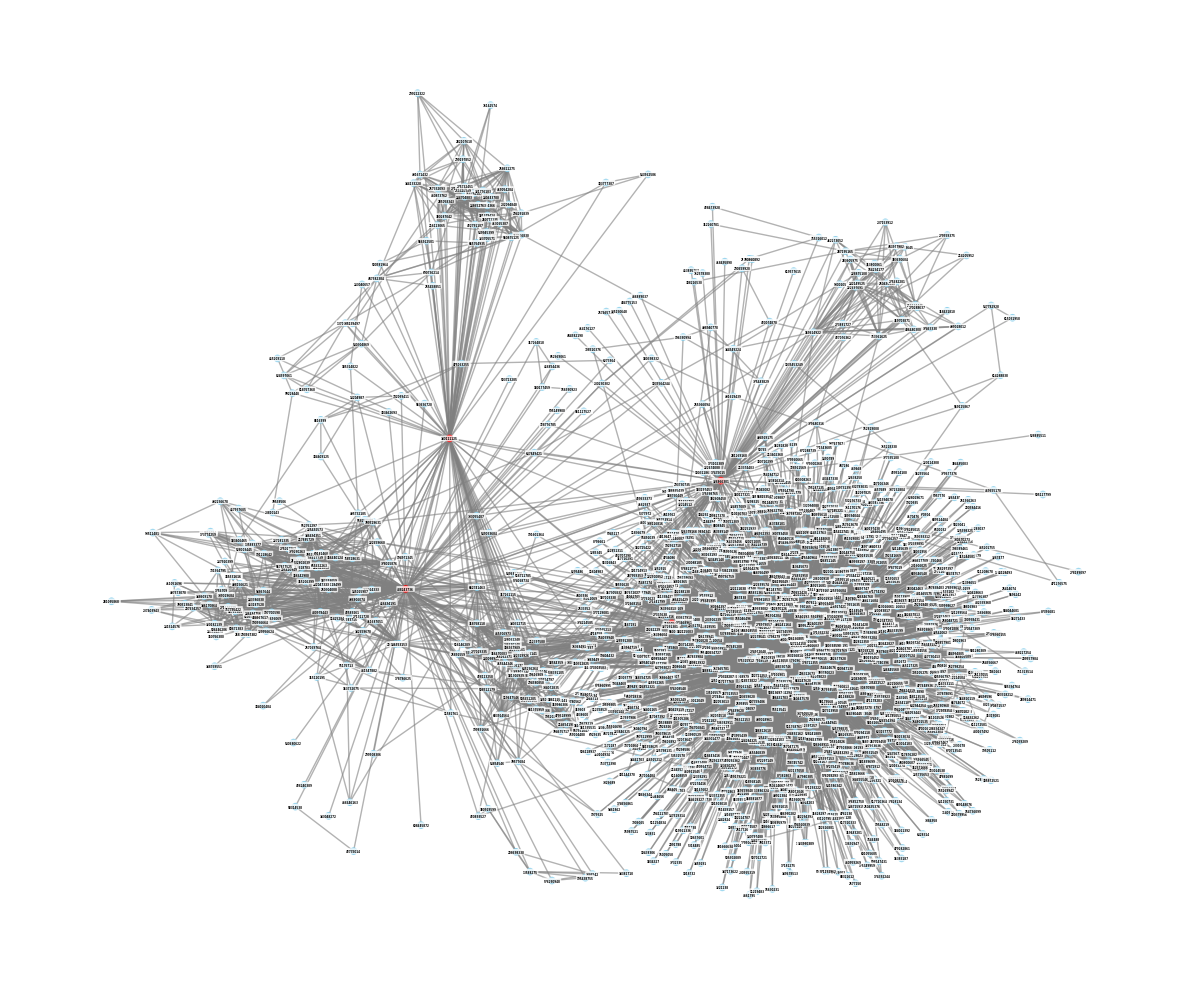

In [ ]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G)

node_colors = []
for node in G.nodes():
    if node in CONTRIBUTORS:
        node_colors.append("red")
    else:
        node_colors.append("skyblue")

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20,
                       alpha=0.9)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.6, width=1)
nx.draw_networkx_labels(G, pos, font_size=2, font_family='DejaVu Sans',
                       font_weight='bold', bbox=dict(boxstyle="round,pad=0.3",
                       facecolor="white", edgecolor="none", alpha=0.8))
plt.axis('off')
plt.tight_layout()
plt.savefig("graph.png", dpi=1000)
plt.show()

## Центральность по посредничеству

*Центральность по посредничеству (betweenness centrality)* — это показатель, который характеризует, насколько важную роль определённый узел играет на пути между другими узлами (определённый узел лежит на кратчайшем пути между двумя другими узлами).

Если у какого-либо узла высокий показатель центральности по посредничеству, тогда он — единственная связь между различными частями сети.

Узел с наибольшей степенью посредничества может контролировать наибольшее число каналов коммуникации.

Реализуем собственную функцию оценки центральности по посредничеству

In [ ]:
def my_betweenness_centrality(G, endpoints=False):
    # Создаем словарь для хранения центральности каждого узла
    betweenness = {node: 0.0 for node in G.nodes()}
    nodes = list(G.nodes()) # Список узлов
    n = len(nodes) # Длина списка

    # Основной алгоритм
    for source in nodes:
        # Структура данных для обхода графа в ширину
        S = []  # Стек для порядка обхода
        dist = {source: 0}  # Расстояния
        sigma = defaultdict(int)  # Количество кратчайших путей
        sigma[source] = 1
        pred = defaultdict(list)  # Предшественники для каждого узла на кратчайших путях
        queue = deque([source])  # Очередь для алгоритма поиска в ширину

        # Процесс обхода в ширину
        while queue:
            # Обработка текущего узла
            current = queue.popleft()
            S.append(current)

            # Обход всех соседей
            for neighbor in G.neighbors(current):
                # Если узел встречается впервые
                if neighbor not in dist:
                    dist[neighbor] = dist[current] + 1 # Увеличиваем расстояние
                    queue.append(neighbor) # Добавляем в очередь

                # Если найден кратчайший путь
                if dist[neighbor] == dist[current] + 1:
                    sigma[neighbor] += sigma[current] # Увеличиваем количество путей
                    pred[neighbor].append(current) # Запоминаем предшественника

        # Обратный проход
        delta = defaultdict(float)
        # Идем от самых дальних узлов к источнику
        while S:
            current = S.pop()
            for predecessor in pred[current]:
                # "Вклад" пропорционально количеству путей
                # (Доля кратчайших путей через предшественника X "вклад" текущего узла)
                delta[predecessor] += (sigma[predecessor] / sigma[current]) * (1 + delta[current])
            #Добавляем вычисленный вклад в общую центральность узла
            if current != source:
                betweenness[current] += delta[current]
                # Учитываем все узлы, включая конечные точки путей
                if endpoints:
                    betweenness[current] += sigma[current]

    # Нормализация
    if n <= 2:
        scale = 1.0
    else:
        scale = 1.0 / ((n - 1) * (n - 2))

    # Нормализация результатов
    for node in betweenness:
        betweenness[node] *= scale

    return betweenness

Используем самописную функцию

In [ ]:
test = my_betweenness_centrality(G)
test

{340121125: 0.08636756160204277,
 11582761: 0.0004612204523427647,
 23810143: 0.0,
 76142574: 0.0,
 95176713: 5.986922665865472e-05,
 99228440: 2.2188018538260165e-06,
 137037837: 3.072187182220639e-06,
 154746387: 0.0,
 155805141: 0.0011255976826131486,
 172710559: 0.09164763863292208,
 178786625: 3.4135413135784873e-07,
 181379424: 3.389426713010974e-05,
 185314822: 5.120311970367731e-07,
 199334366: 4.064402690229533e-06,
 207383715: 8.674377307641583e-07,
 209914889: 2.988632492401691e-05,
 212397580: 1.3658626095233208e-05,
 216123065: 4.1044305258709e-06,
 219305476: 0.22095493319135134,
 228061240: 0.0009547386910183429,
 228741614: 3.167419133823628e-05,
 229814797: 2.7922454935032006e-06,
 232094840: 2.2639093640411613e-06,
 236690140: 0.00012096138646486098,
 238384014: 0.0002565582905600409,
 240098981: 0.0001532275173192403,
 240443780: 6.285108085264251e-07,
 243040657: 0.0,
 244704883: 9.81174968998436e-06,
 248652763: 2.256075485052549e-06,
 250304008: 8.801609994606646e

Запуск алгоритма через готовую функцию (сверка результатов)

In [ ]:
bc = nx.betweenness_centrality(G)

print("Центральность по посредничеству:")
for node, score in bc.items():
    print(f'{node}: {score}')

Центральность по посредничеству:
340121125: 0.08636756160204277
11582761: 0.0004612204523427647
23810143: 0.0
76142574: 0.0
95176713: 5.986922665865472e-05
99228440: 2.2188018538260165e-06
137037837: 3.072187182220639e-06
154746387: 0.0
155805141: 0.0011255976826131486
172710559: 0.09164763863292208
178786625: 3.4135413135784873e-07
181379424: 3.389426713010974e-05
185314822: 5.120311970367731e-07
199334366: 4.064402690229533e-06
207383715: 8.674377307641583e-07
209914889: 2.988632492401691e-05
212397580: 1.3658626095233208e-05
216123065: 4.1044305258709e-06
219305476: 0.22095493319135134
228061240: 0.0009547386910183429
228741614: 3.1674191338236286e-05
229814797: 2.7922454935032006e-06
232094840: 2.2639093640411613e-06
236690140: 0.00012096138646486096
238384014: 0.0002565582905600409
240098981: 0.00015322751731924026
240443780: 6.285108085264251e-07
243040657: 0.0
244704883: 9.81174968998436e-06
248652763: 2.256075485052549e-06
250304008: 8.801609994606646e-06
252606151: 0.0
2554588

Центральности авторов работы (самописная функция)

In [ ]:
for user in CONTRIBUTORS:
  print(f"{user} -> {test[user]}")

488243736 -> 0.12644140311821983
340121125 -> 0.08636756160204277
326866301 -> 0.10625004278170537
219305476 -> 0.22095493319135134


Центральности авторов работы (готовая функция)

In [ ]:
for user in CONTRIBUTORS:
  print(f"{user} -> {bc[user]}")

488243736 -> 0.12644140311821983
340121125 -> 0.08636756160204277
326866301 -> 0.10625004278170537
219305476 -> 0.22095493319135134


## Центральность по близости

Здесь будет написана своя функция по рассчету центральности по близости для графа. Центральность по близости — показатель того, насколько близко узел расположен к остальным узлам сети. В нашей ситуации центральность по близости показывает близость человека ко всем остальным пользователям в сети.

In [ ]:
def custom_closeness_centrality(G):
    closeness = {}
    # Реализуем поиск в ширину для нахождения расстояний
    for node in G.nodes():
        # Словарь distances будет хранить расстояния от текущего узла до остальных
        distances = {node: 0}
        queue = [node]

        while queue:
            current = queue.pop(0)
            # Для текущего узла перебираем всех соседей
            for neighbor in G.neighbors(current):
                # Проверяем, не посещали ли мы уже этого соседа
                if neighbor not in distances:
                    # Записываем расстояние до соседа
                    distances[neighbor] = distances[current] + 1
                    queue.append(neighbor)

        # Считаем сумму всех расстояний
        total_distance = sum(distances.values())
        reachable_count = len(distances)

        # Рассчитываем центральность по формуле
        if total_distance > 0:
            closeness[node] = (reachable_count - 1) / total_distance
        else:
            closeness[node] = 0

    return closeness

Теперь считаем центральности через выше написанную функцию и встроенную функцию.

In [ ]:
custom_close_centr = custom_closeness_centrality(G)
lib_close_centr = nx.closeness_centrality(G)

В этой ячейке выводим центральности авторов работы по библиотечной функции

In [ ]:
for user in CONTRIBUTORS:
  print(f"{user} -> {lib_close_centr[user]}")

488243736 -> 0.3866150442477876
340121125 -> 0.3799945637401468
326866301 -> 0.3817586018569088
219305476 -> 0.5202828433196874


В этой ячейке выводим центральности авторов работы по собственной функции

In [ ]:
for user in CONTRIBUTORS:
  print(f"{user} -> {custom_close_centr[user]}")

488243736 -> 0.3866150442477876
340121125 -> 0.3799945637401468
326866301 -> 0.3817586018569088
219305476 -> 0.5202828433196874
